# Sacred Cycles
*Simulating Menstrual-esque Cycles Using Injected Estrogen*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys

sys.path.insert(0, "../")
from transkit import pharma, fit, medications

In [2]:
t3_ec_cali = np.array([0.000000000, 0.900172119])
t2_ev_cali = np.array([0.000000000, 1.468750000])

calibrated_medications = dict(medications.medications)
calibrated_medications["ec"] = pharma.calibratedDoseResponse(
    calibrated_medications["ec"],
    t3_ec_cali)
calibrated_medications["ev"] = pharma.calibratedDoseResponse(
    calibrated_medications["ev"],
    t2_ev_cali)

# Optimization

This constructs an optimization problem solving for optimal injection doses and times to fit a desired blood level profile.

## Menstrual

In [4]:
def molarConcToMassConc(molar_conc, molar_weight):
    """Converts pmol/L to pg/mL for a substance of a particular molar weight.
    
    molar         Molar concentration in pmol/L [array like].
    molar_weight  Molar weight of substance in g/mol."""
    return molar_conc * molar_weight * 10**-3


e2_mol = 272.388 # g/mol
e1_mol = 270.366 # g/mol

# Stricker2006, referenced from https://en.wikiversity.org/wiki/WikiJournal_of_Medicine/Reference_ranges_for_estradiol,_progesterone,_luteinizing_hormone_and_follicle-stimulating_hormone_during_the_menstrual_cycle
menstrual_e2 = molarConcToMassConc(np.array([118.42, 133.01, 133.17, 125.95, 134.65, 151.33, 159.48, 170.34, 195.9, 228.2, 269.07, 343.68, 477.27, 661.19, 914.84, 780.76, 320.59, 261.32, 338.94, 454.07, 499.49, 497.07, 531.14, 504.39, 499.18, 526.68, 350.65, 322.24, 229.7, 249.28, 150.0, 118.42, 118.42, 118.42, 118.42]),
                                   e2_mol)

menstrual_fit_start_t = pd.to_datetime("2020-01-01 12:00:00")
menstrual_fit_range_t = 6*7 - 1 + len(menstrual_e2) # 6 weeks to steady state, then the menstrual curve.
menstrual_fit_t  = pd.date_range(menstrual_fit_start_t,
                                 menstrual_fit_start_t + pd.to_timedelta(menstrual_fit_range_t, unit='D'),
                                 freq='1D')
menstrual_fit_e2 = np.append(np.full(6*7, menstrual_e2[0]), menstrual_e2)

menstrual_fit = pd.Series(menstrual_fit_e2, index=menstrual_fit_t)
menstrual_fit_results = {}

### Estradiol Cypionate

Least squares figures out some real gymnastics to get this close, but EC doesn't decay quickly enough to mimic the big peak very well. I wonder if this result is still in range for some realistic cycle, even if it doesn't quite match the mean?

In [5]:
doses = pharma.createDosesCycle(
    "ec",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ec"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:13]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[12]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ec"],
    max_nfev=35,
    ftol=1e-2,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0278e+05                                    1.05e+05    
       1              2         2.6902e+04      7.59e+04       3.07e+00       2.66e+04    
       2              3         1.3359e+04      1.35e+04       1.85e+00       6.11e+03    
       3              4         1.2104e+04      1.25e+03       1.25e-01       7.58e+03    
       4              5         1.1993e+04      1.11e+02       1.04e-01       1.40e+03    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.0278e+05, final cost 1.1993e+04, first-order optimality 1.40e+03.


Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.268         ec
2020-01-04 12:00:00.000000000      0.268         ec
2020-01-07 12:00:00.000000000      0.268         ec
2020-01-10 12:00:00.000000000      0.268         ec
2020-01-13 12:00:00.000000000      0.268         ec
2020-01-16 12:00:00.000000000      0.268         ec
2020-01-19 12:00:00.000000000      0.268         ec
2020-01-22 12:00:00.000000000      0.268         ec
2020-01-25 12:00:00.000000000      0.268         ec
2020-01-28 12:00:00.000000000      0.268         ec
2020-01-31 12:00:00.000000000      0.268         ec
2020-02-03 12:00:00.000000000      0.268         ec
2020-02-06 12:00:00.000000000      0.268         ec
2020-02-09 12:00:00.000000000      0.395         ec
2020-02-13 07:13:23.244672000      0.445         ec
2020-02-16 08:26:01.814323200      0.541         ec
2020-02-19 04:48:27.542160000      0.702         ec
2020-02-22 02:07:34.094179200      1.976      

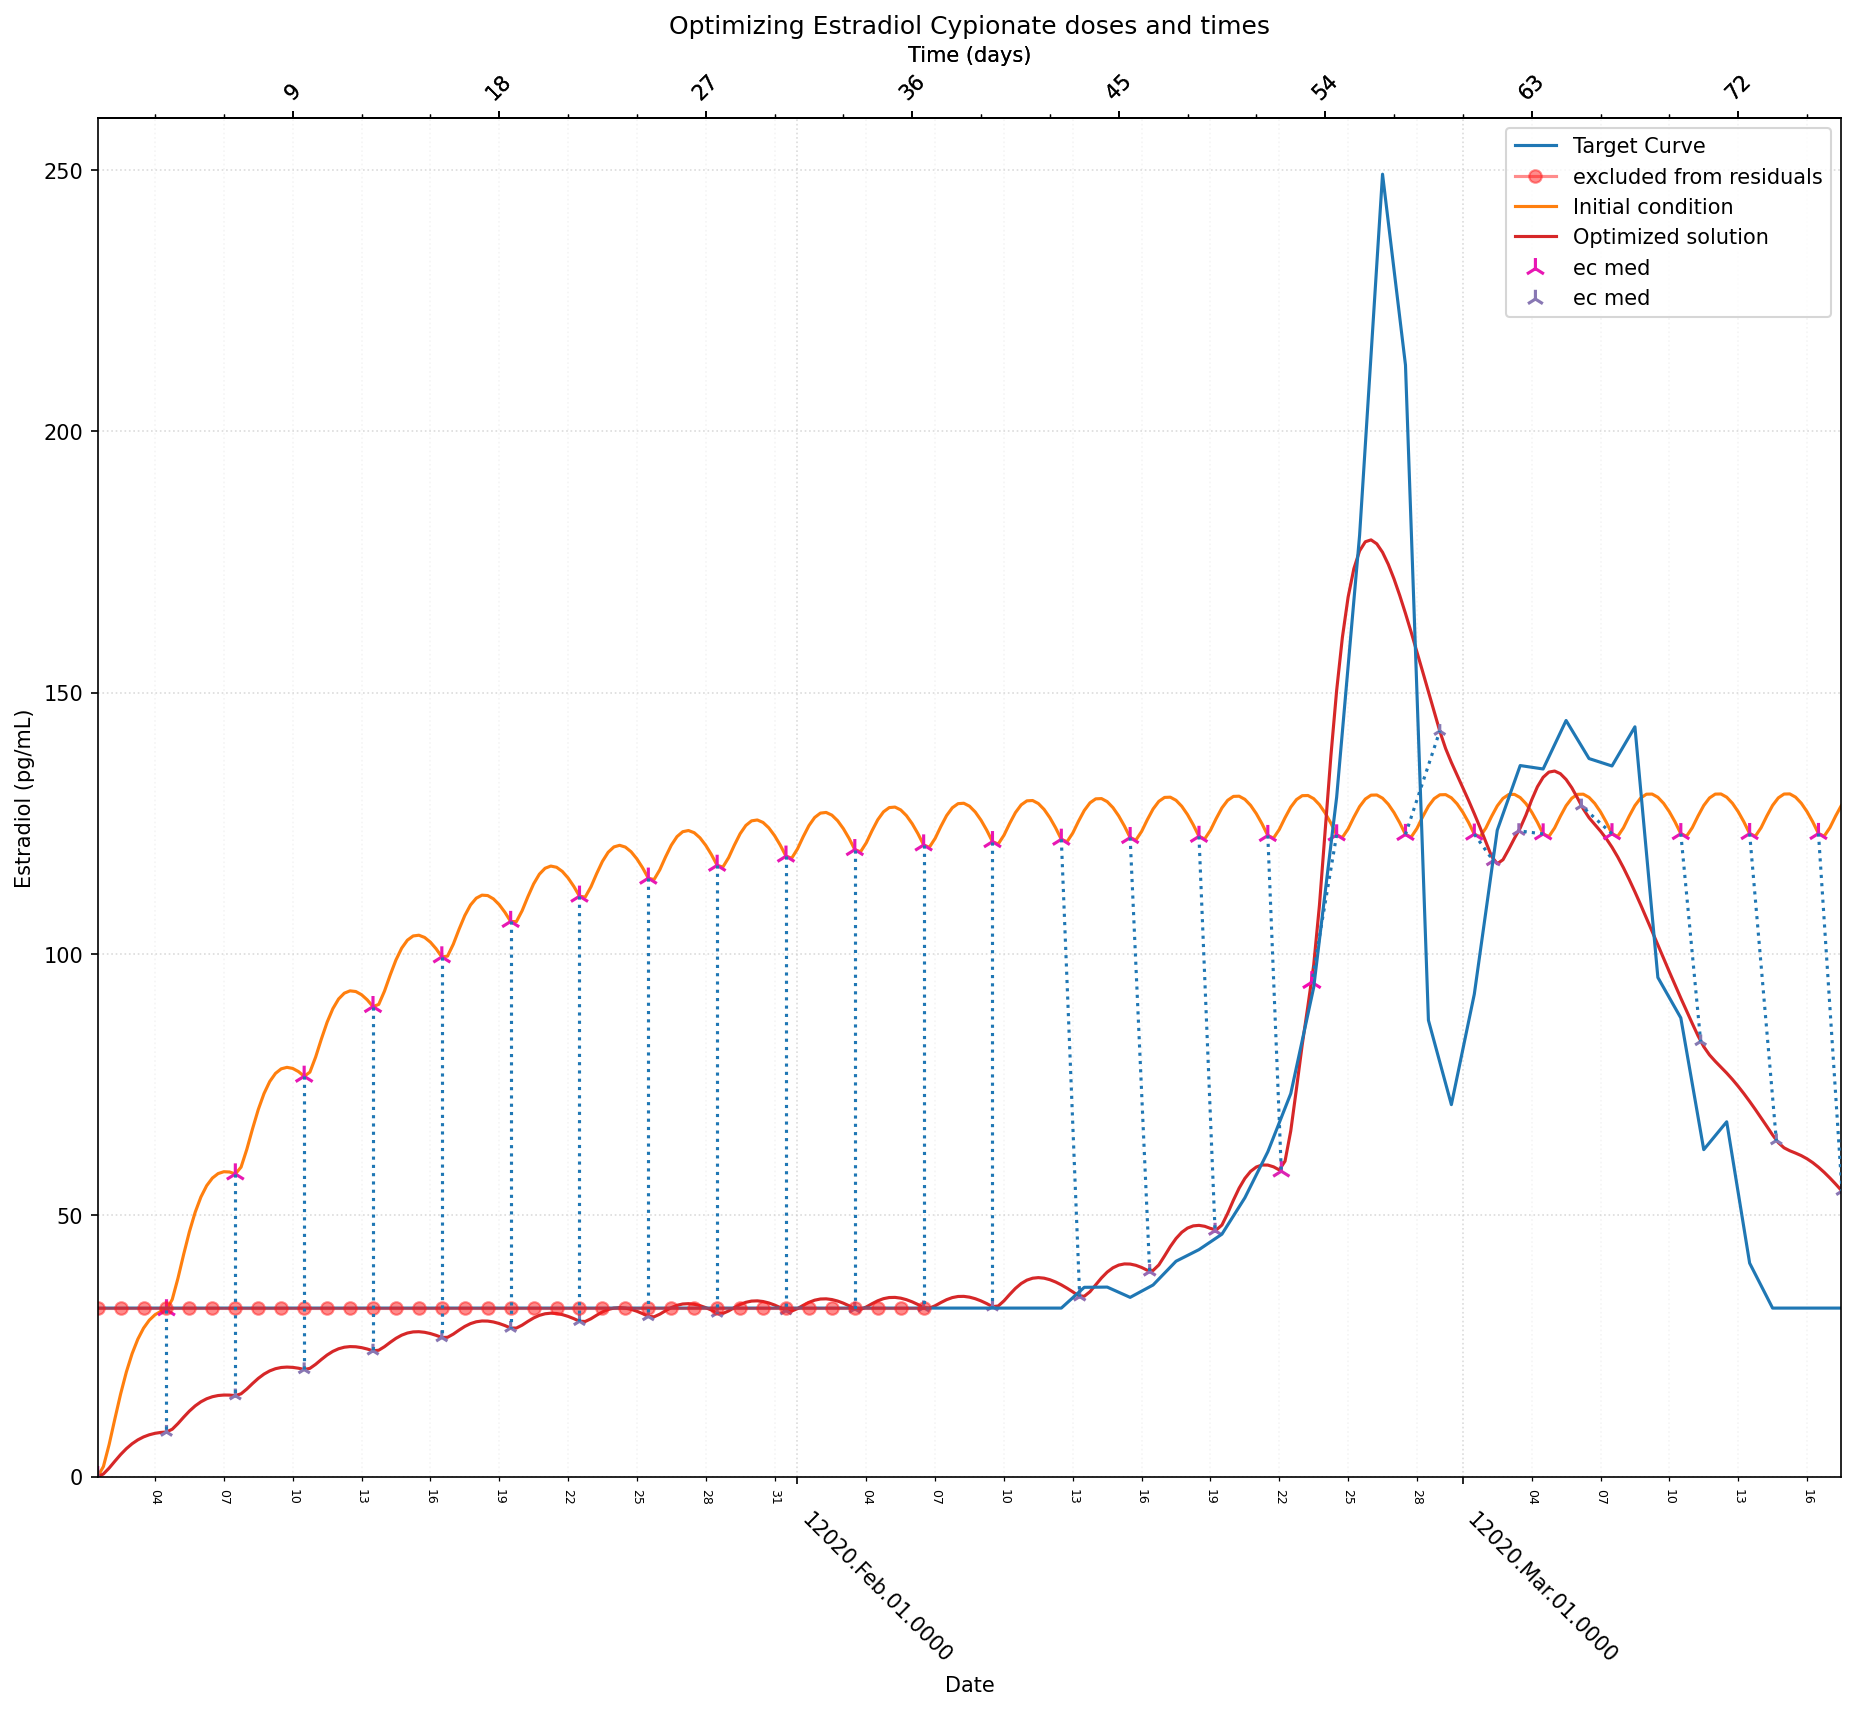

In [6]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ec"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ec"]["doses_optim"])

### Estradiol Valerate

After all this work, it looks like EV can actually fit a realistic menstrual curve better than EC can. Wow! That's incredibly unexpected for me but I guess I was doing all of the curve fitting stuff at unrealistic time scales. The interesting bit here is that, because of the big intense spike in estradiol prior to ovulation, the decay rate of EC isn't able to keep up. EV, with it's big quick peak, and fast decay, is perfectly suited to mimicing that peak in estradiol.

Somatically it's almost like taking EV is like ovulating with every injection–and that actually resonates with my subjective experience pretty well. EV has a kind of dynamicism and responsiveness and punchiness to it. EC is much softer, pillowy, flowy, floaty. EV is unsurprisingly well suited to fitting to quicker, more dynamic curves; EC is better suited to gentler, more stable curves. They each have strengths. I have no idea how you'd get it prescribed, but I wonder if mixing medicines could work. Like using EC for most injections, but using EV for just around the big peak. Or maybe spiking with pills there. Once you've figured out the calibration for your body, a whole lot of magic is possible!

At realistic time scales there's a lot more to "stable levels" than just optimizing for constant e2 levels, that's for sure! I am feeling a big expansion in my understanding of all this, and how it fits together somatically. It's not what I was expecting, and that's really exciting! Laying it all out on a timeline is really important. I feel some inklings and sparking connections happening...

In [7]:
doses = pharma.createDosesCycle(
    "ev",
    menstrual_fit_range_t,
    '3D',
    start_date=menstrual_fit_start_t)
menstrual_fit_results["ev"] = fit.initializeFit(
    doses,
    calibrated_medications,
    menstrual_fit,
    dose_bounds=(0.0, 10.0),
    time_bounds=14*['fixed'] + (len(doses)-14)*['midpoints'],
    equal_doses=[doses.index[:14]], # All injections in the ramp-up to steady-state should be equal
    exclude_area=menstrual_fit[:doses.index[13]].index) # Only optimize starting from the first injection after steady-state
fit.runLeastSquares(
    menstrual_fit_results["ev"],
    max_nfev=35,
    ftol=1e-2,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9619e+05                                    2.04e+05    
       1              2         6.4647e+04      2.32e+05       2.37e+00       5.24e+04    
       2              3         1.5458e+04      4.92e+04       1.77e+00       2.10e+04    
       3              4         7.2642e+03      8.19e+03       7.29e-01       5.83e+03    
       4              5         6.8302e+03      4.34e+02       1.03e-01       2.37e+03    
       5              6         6.5079e+03      3.22e+02       7.43e-02       1.15e+04    
       6              7         6.4697e+03      3.82e+01       2.98e-02       7.12e+02    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 2.9619e+05, final cost 6.4697e+03, first-order optimality 7.12e+02.


Optimized Doses:
                                     dose medication
2020-01-01 12:00:00.000000000      0.168         ev
2020-01-04 12:00:00.000000000      0.168         ev
2020-01-07 12:00:00.000000000      0.168         ev
2020-01-10 12:00:00.000000000      0.168         ev
2020-01-13 12:00:00.000000000      0.168         ev
2020-01-16 12:00:00.000000000      0.168         ev
2020-01-19 12:00:00.000000000      0.168         ev
2020-01-22 12:00:00.000000000      0.168         ev
2020-01-25 12:00:00.000000000      0.168         ev
2020-01-28 12:00:00.000000000      0.168         ev
2020-01-31 12:00:00.000000000      0.168         ev
2020-02-03 12:00:00.000000000      0.168         ev
2020-02-06 12:00:00.000000000      0.168         ev
2020-02-09 12:00:00.000000000      0.168         ev
2020-02-12 15:50:15.721756800      0.233         ev
2020-02-16 03:13:38.995449600      0.290         ev
2020-02-19 10:55:42.872188800      0.470         ev
2020-02-22 22:10:21.033206400      0.929      

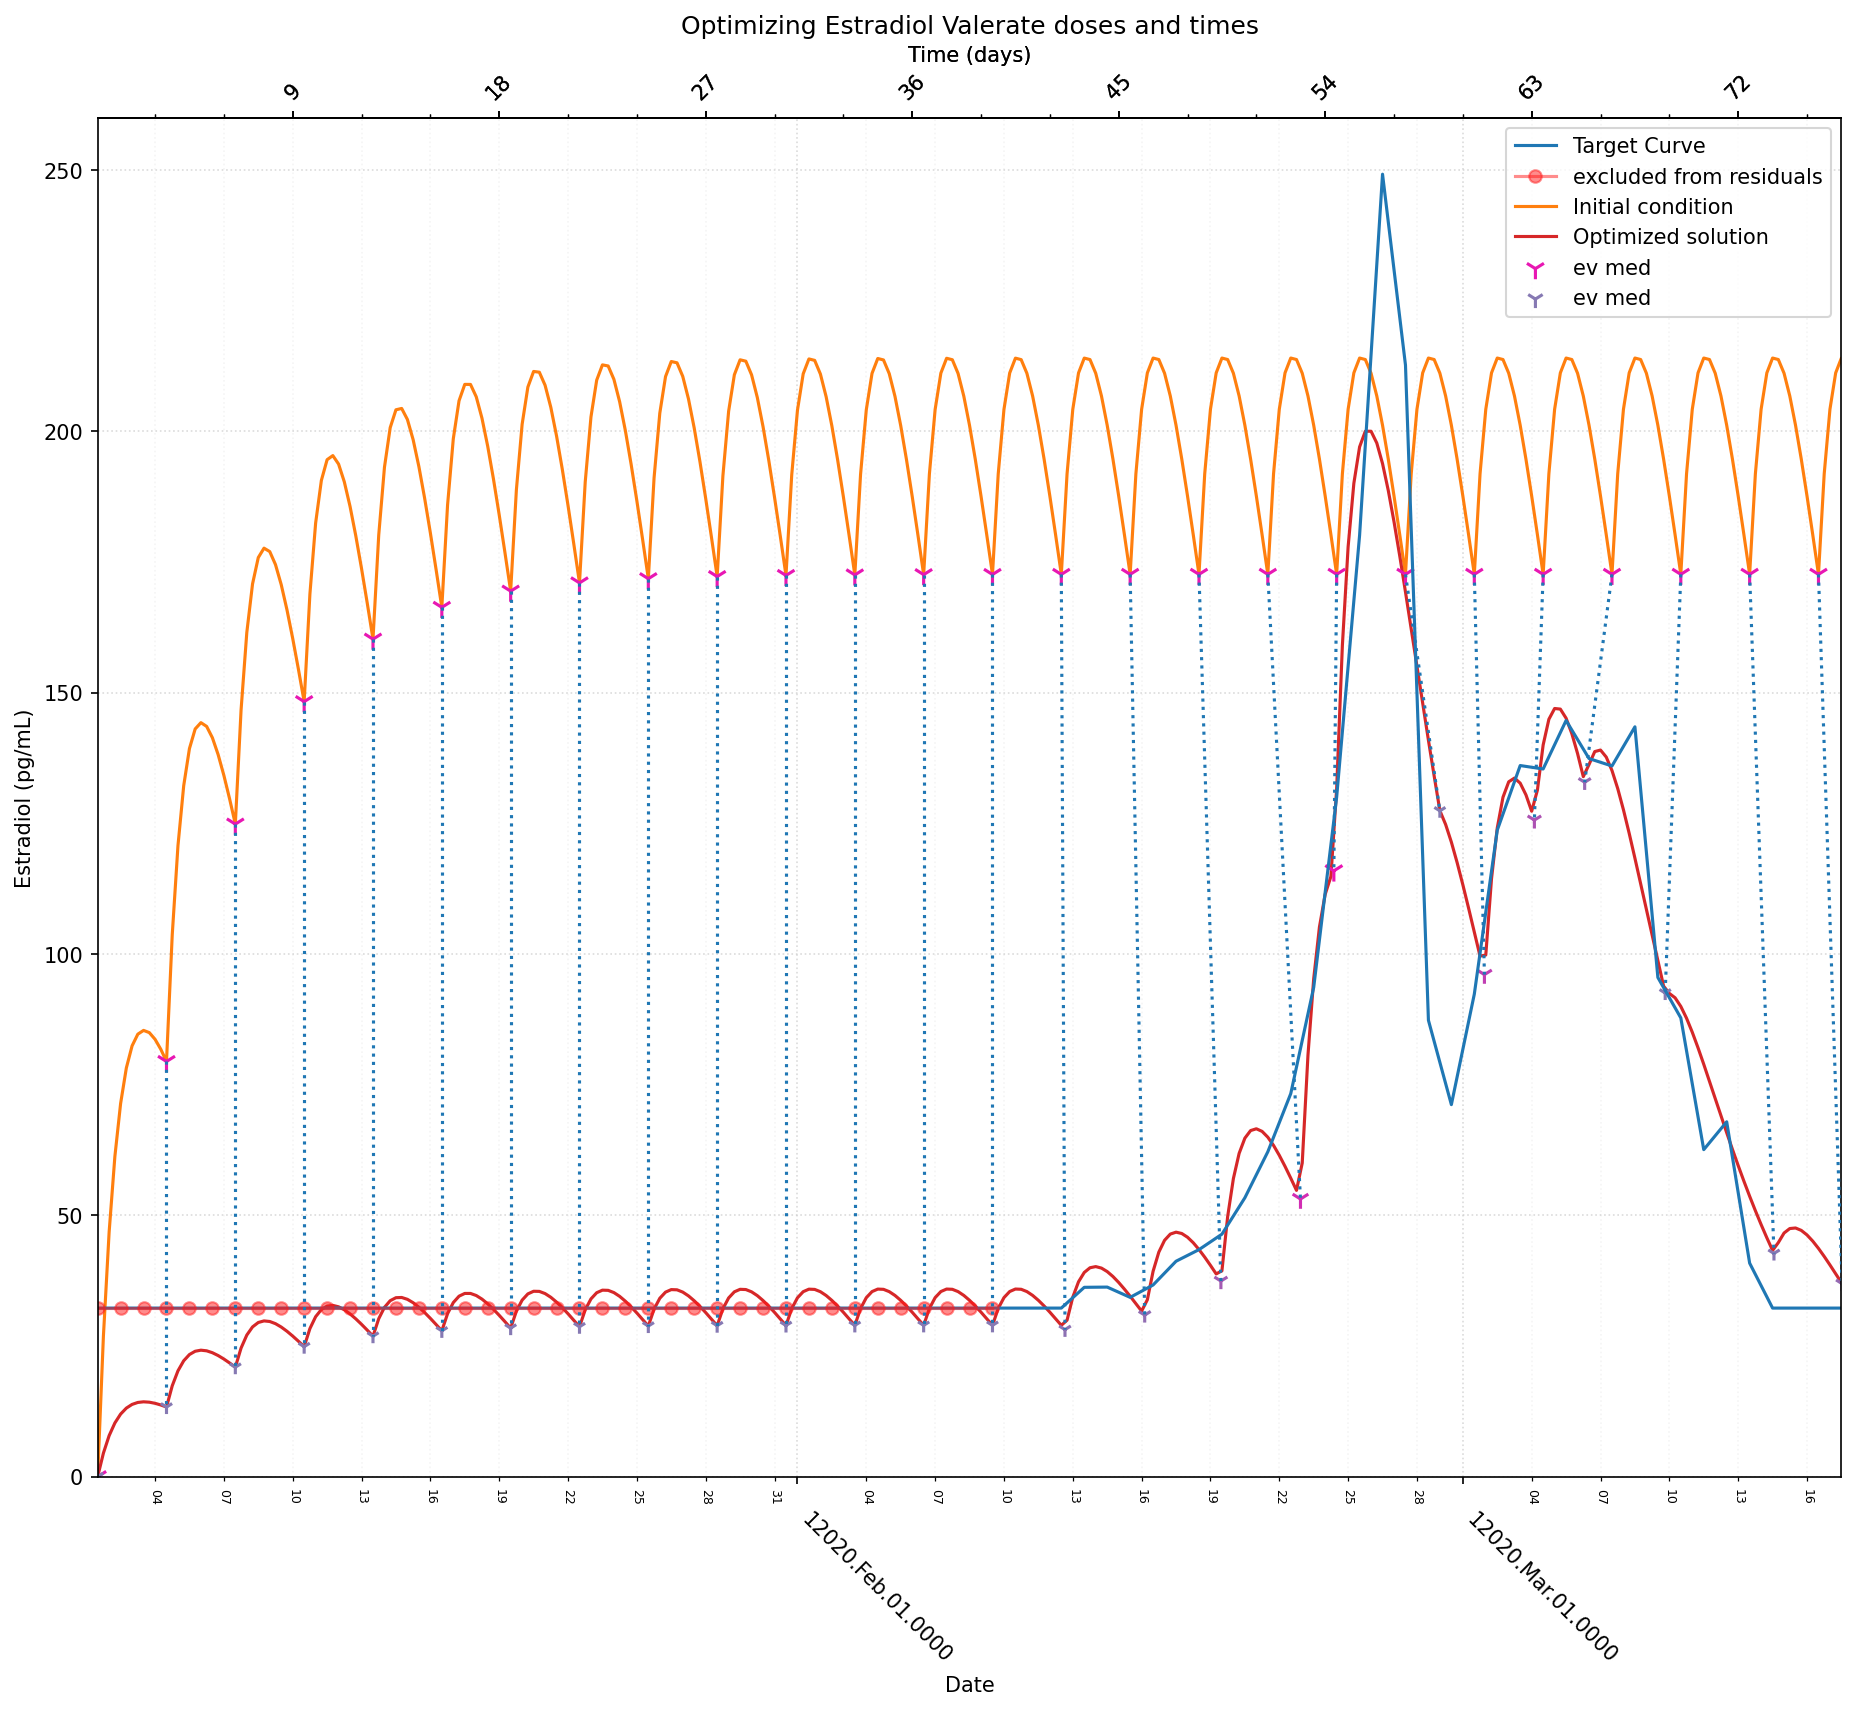

In [9]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=260)
ax.set_yticks(range(0, 261, 50))
fit.plotOptimizationRun(fig, ax, menstrual_fit_results["ev"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", menstrual_fit_results["ev"]["doses_optim"])

## Step function

### Estradiol Cypionate (optimize doses & times)

It's a loading dose! This demonstrates the control theory intuition that, if desired, you can reach a steady state level more quickly by using several large injections to reach the target level and then reducing to a regular consistent dose. That doesn't mean it would be good for your body! But, looking purely at blood concentration levels, it's possible. The lsq solution here achieves a 150pg/mL change in level, steady-to-steady, in just 9 days (in comparison to 6 weeks for a linear, consistent increase in dose.

In [18]:
step_func = lambda T: int(T>=pd.to_datetime('1970-02-01')) * (250.0) +\
                       int(T<pd.to_datetime('1970-02-01'))  * (100.0)
step_target_x = pd.date_range(0, pd.to_datetime(62.0, unit='D'), freq='12H')
step_target_y = np.array([step_func(T) for T in step_target_x])

step_target = pd.Series(step_target_y, index=step_target_x)
step_results = {}

In [19]:
step_results["ec_doses_and_times"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 62.0, '3D'),
    calibrated_medications,
    step_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=7*['fixed'] + 8*['midpoints'] + 6*['fixed'])
fit.runLeastSquares(
    step_results["ec_doses_and_times"],
    max_nfev=35,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1979e+05                                    3.65e+05    
       1              2         5.1144e+04      4.69e+05       3.70e+00       6.35e+04    
       2              3         2.0670e+04      3.05e+04       1.78e+00       1.48e+04    
       3              4         1.6607e+04      4.06e+03       1.16e+00       4.12e+03    
       4              5         1.4950e+04      1.66e+03       1.20e+00       3.22e+03    
       5              6         1.4665e+04      2.85e+02       1.76e+00       5.21e+03    
       6              7         1.3885e+04      7.80e+02       9.77e-01       8.25e+03    
       7              8         1.3681e+04      2.04e+02       6.06e-01       1.80e+03    
       8              9         1.3533e+04      1.48e+02       6.40e-01       6.81e+02    
       9             10         1.3459e+04      7.47e+01       3.55e-01       2.65e+02    

Optimized Doses:
                                     dose medication
1970-01-01 00:00:00.000000000      3.575         ec
1970-01-04 00:00:00.000000000      0.000         ec
1970-01-07 00:00:00.000000000      0.963         ec
1970-01-10 00:00:00.000000000      0.743         ec
1970-01-13 00:00:00.000000000      0.796         ec
1970-01-16 00:00:00.000000000      0.777         ec
1970-01-19 00:00:00.000000000      0.812         ec
1970-01-22 05:30:15.732777600      0.871         ec
1970-01-25 14:55:22.349020800      0.900         ec
1970-01-29 11:59:59.999568000      1.346         ec
1970-01-30 21:59:05.284636800      5.000         ec
1970-02-03 16:48:04.319222400      1.598         ec
1970-02-06 03:00:37.427356800      1.651         ec
1970-02-08 19:00:26.678534400      1.864         ec
1970-02-11 19:24:37.349654400      2.064         ec
1970-02-15 00:00:00.000000000      2.035         ec
1970-02-18 00:00:00.000000000      1.946         ec
1970-02-21 00:00:00.000000000      1.970      

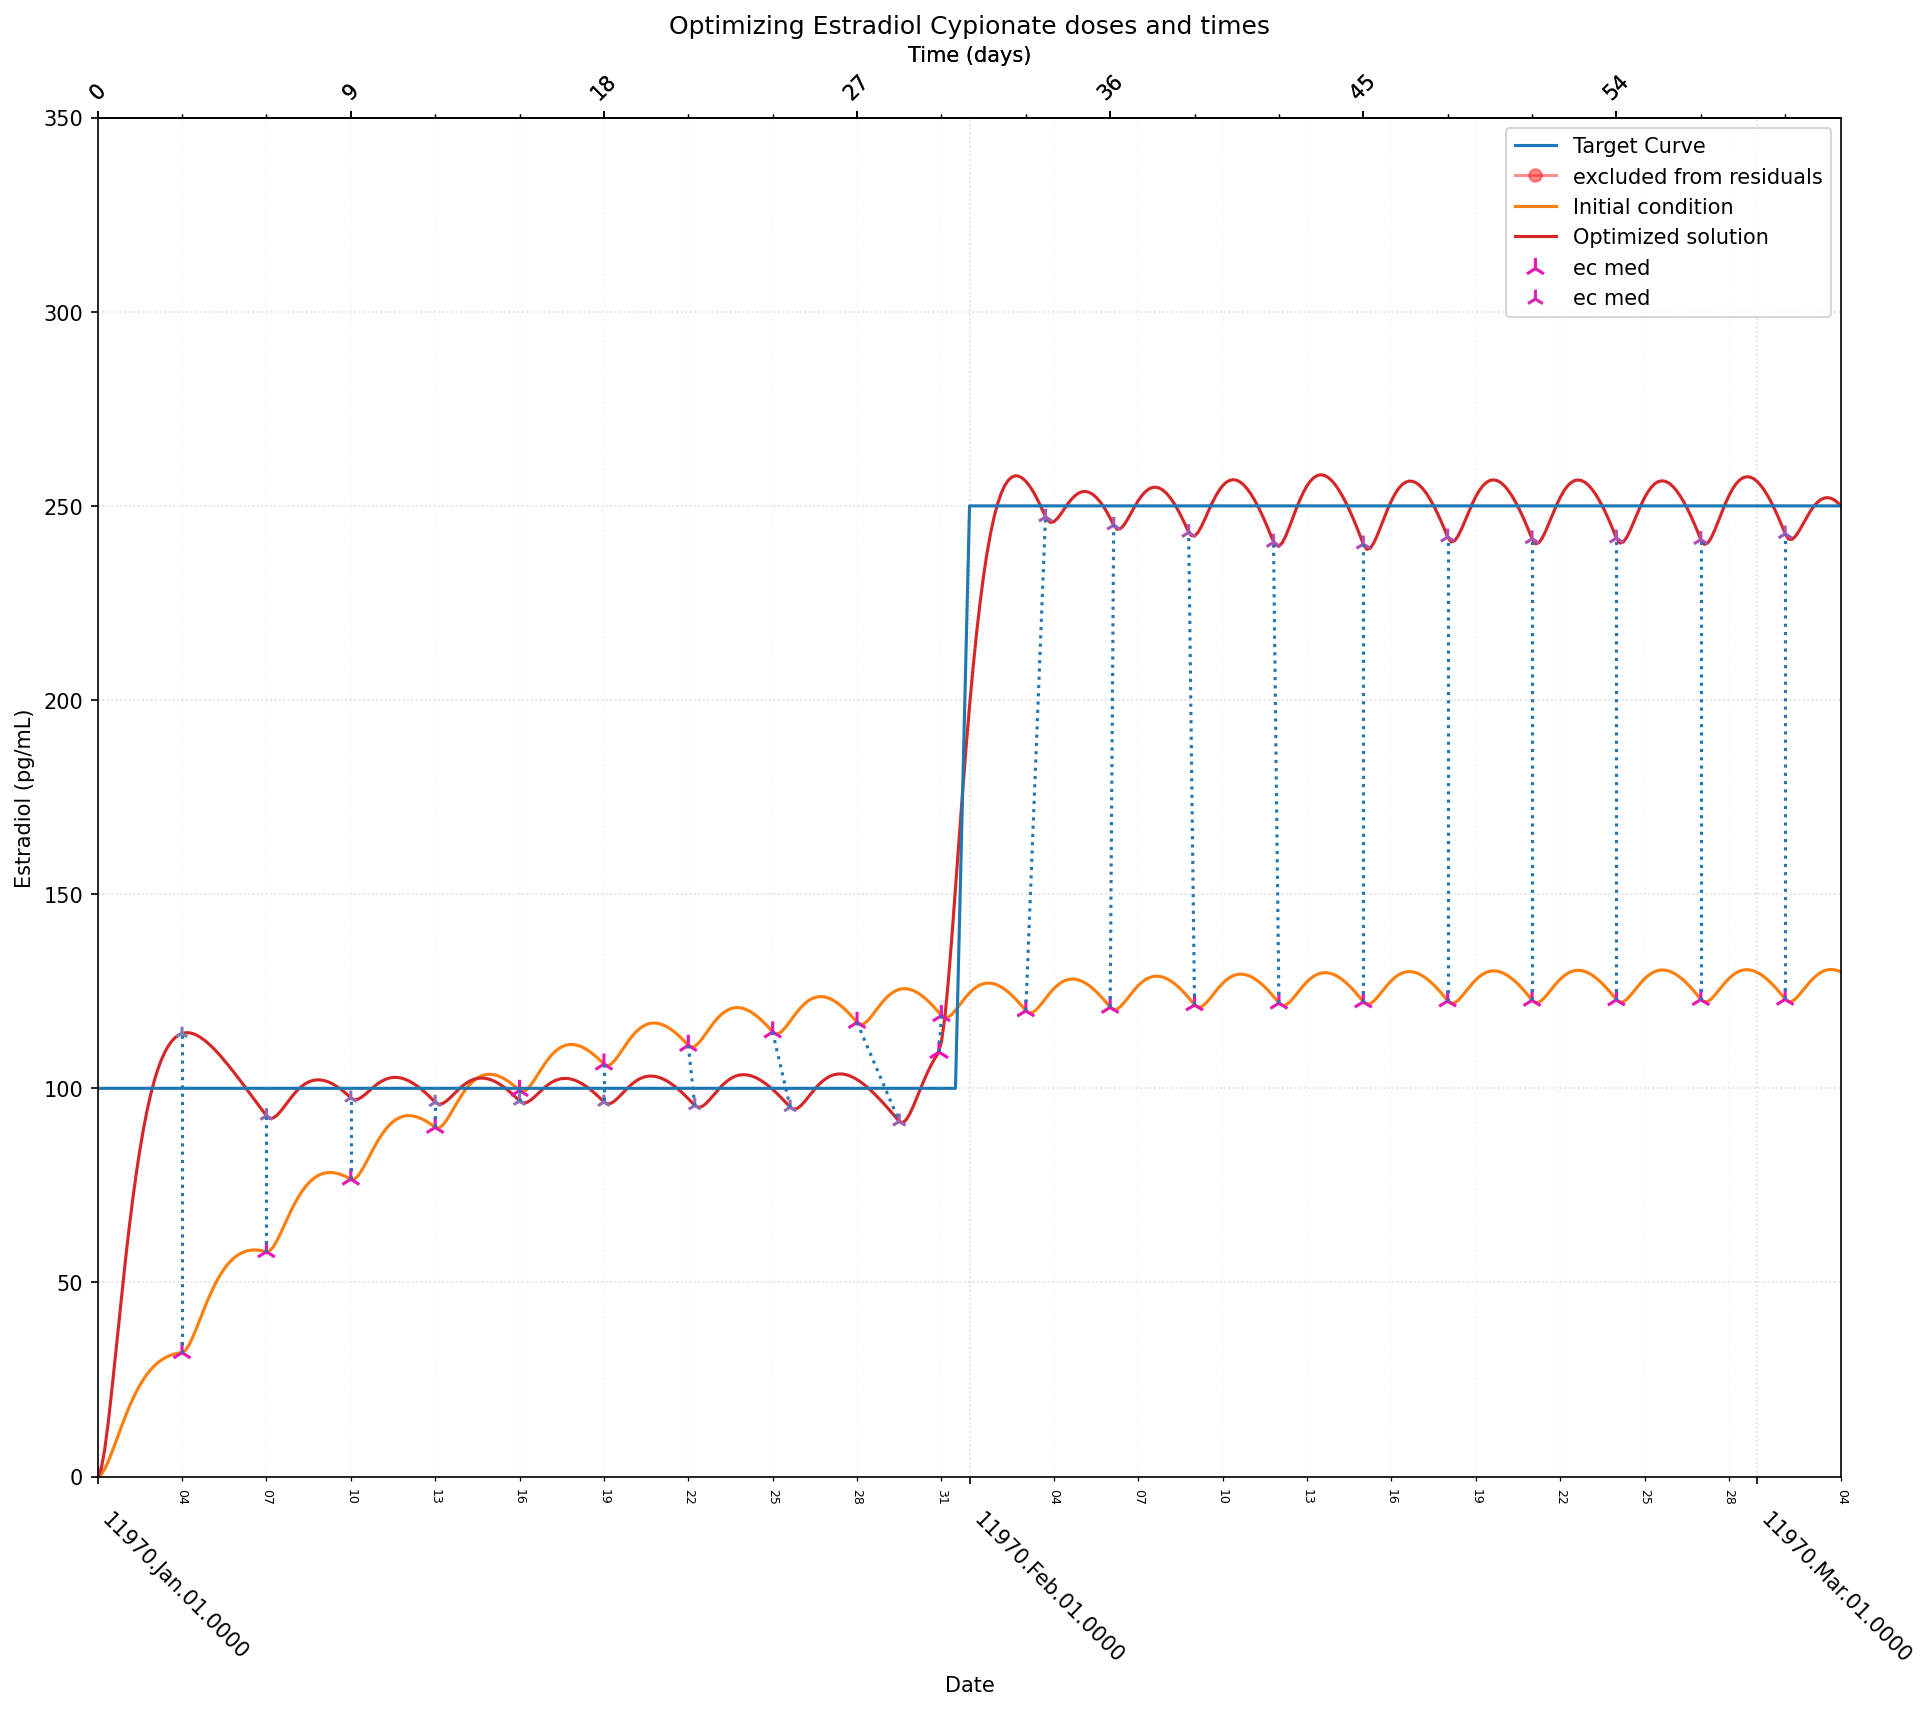

In [20]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, step_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", step_results["ec_doses_and_times"]["doses_optim"])

## Sine Wave

*try to fit blood levels to a sine wave curve*

In [10]:
cycling_start_t = 42.0 # days
sine_target_func = lambda T: int(T>=cycling_start_t) * (250.0 + 50.0*np.sin((2*math.pi/30)*(T-cycling_start_t))) +\
                             int(T<cycling_start_t)  * (250.0)
sine_start_t = pd.to_datetime("2020")
sine_target_x = pd.date_range(sine_start_t, sine_start_t + pd.to_timedelta(90.0, unit='D'), freq='18H')
sine_target_y = np.array([sine_target_func(pharma.timeDeltaToDays(T - sine_target_x[0])) for T in sine_target_x])

sine_target = pd.Series(sine_target_y, index=sine_target_x)
sine_results = {}

### Least Squares (Estradiol Cypionate, optimizing doses)

Works ok, doesn't find a great solution right now.

In [11]:
sine_results["ec_doses"] = fit.initializeFit(
    pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020"),
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds='fixed')
fit.runLeastSquares(
    sine_results["ec_doses"],
    max_nfev=35,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2647e+06                                    3.61e+05    
       1              2         1.8978e+05      1.07e+06       5.00e+00       8.99e+04    
       2              3         9.2027e+04      9.78e+04       1.95e+00       2.24e+04    
       3              4         7.6157e+04      1.59e+04       1.04e+00       4.90e+03    
       4              5         7.1915e+04      4.24e+03       7.03e-01       6.53e+02    
       5              6         7.1278e+04      6.37e+02       1.85e-01       2.83e+01    
       6              7         7.1253e+04      2.50e+01       1.68e-02       2.31e-01    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.2647e+06, final cost 7.1253e+04, first-order optimality 2.31e-01.


Optimized Doses:
                  dose medication
2020-01-01      5.000         ec
2020-01-04      3.930         ec
2020-01-07      1.343         ec
2020-01-10      2.111         ec
2020-01-13      1.929         ec
2020-01-16      1.972         ec
2020-01-19      1.962         ec
2020-01-22      1.964         ec
2020-01-25      1.963         ec
2020-01-28      1.963         ec
2020-01-31      1.964         ec
2020-02-03      1.962         ec
2020-02-06      1.970         ec
2020-02-09      1.938         ec
2020-02-12      2.786         ec
2020-02-15      2.741         ec
2020-02-18      2.360         ec
2020-02-21      1.848         ec
2020-02-24      1.375         ec
2020-02-27      1.128         ec
2020-03-01      1.200         ec
2020-03-04      1.563         ec
2020-03-07      2.080         ec
2020-03-10      2.552         ec
2020-03-13      2.800         ec
2020-03-16      2.728         ec
2020-03-19      2.363         ec
2020-03-22      1.848         ec
2020-03-25      1.370    

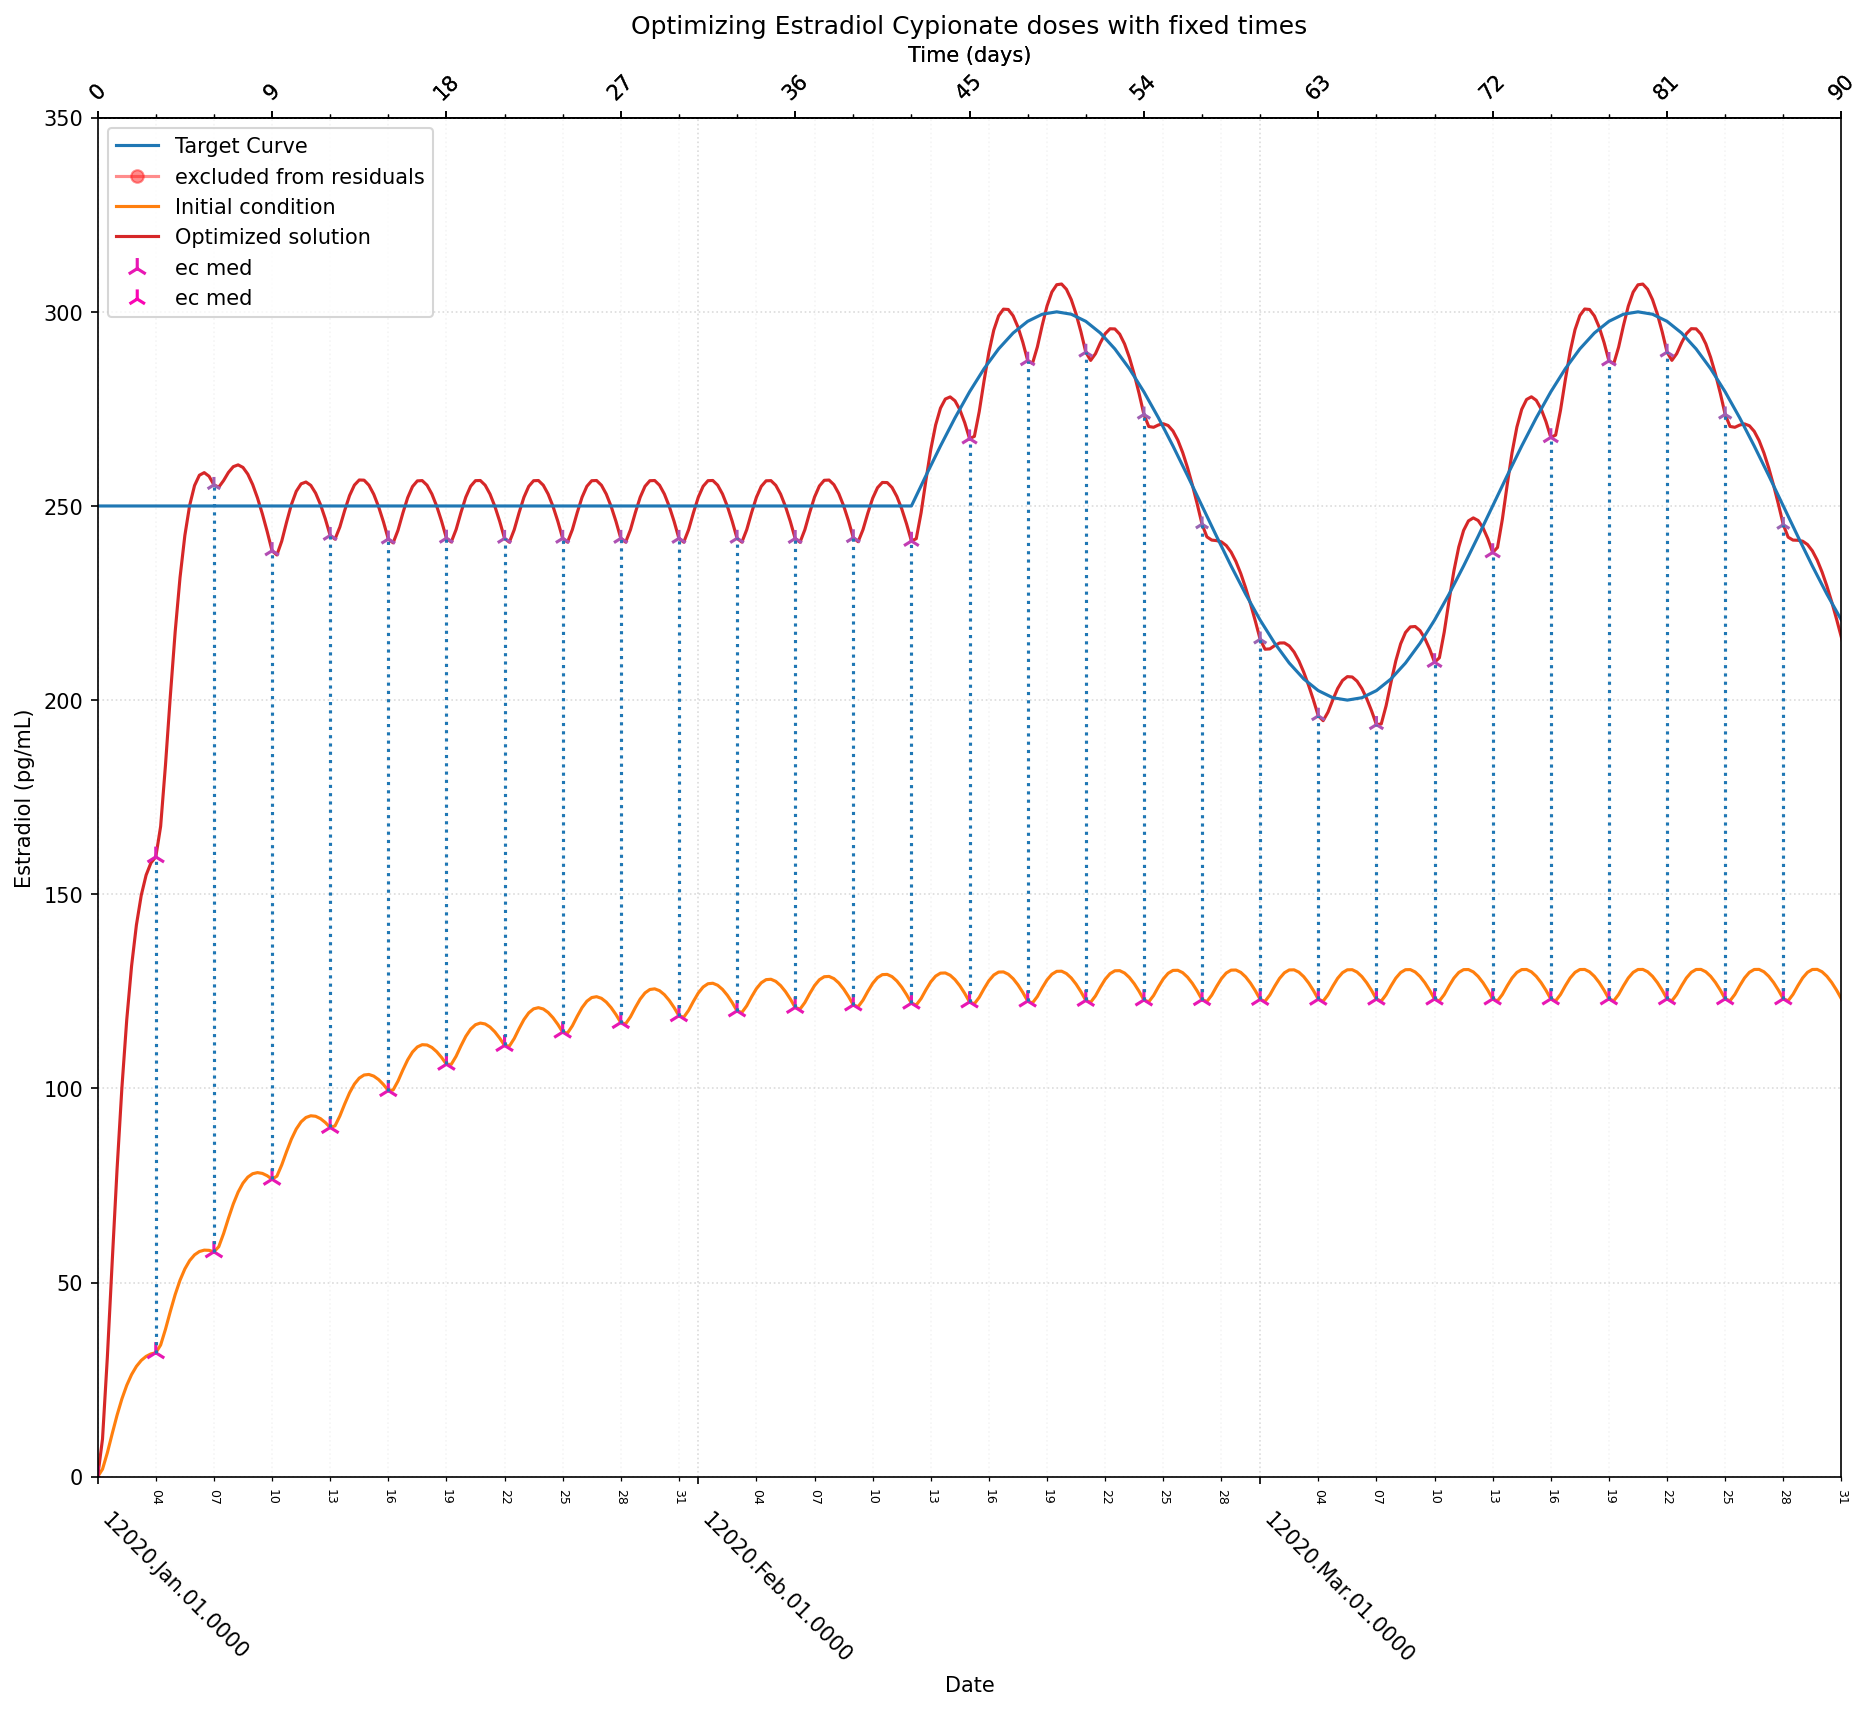

In [12]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses with fixed times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses"]["doses_optim"])

### Least Squares (Estradiol Cypionate, Doses & Times)

This works awesome!

In [13]:
doses = pharma.createDosesCycle("ec", 90.0, '3D', start_date="2020")
sine_results["ec_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ec_doses_and_times"],
    max_nfev=30,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2647e+06                                    3.61e+05    
       1              2         1.8999e+05      1.07e+06       5.72e+00       9.22e+04    
       2              3         8.0224e+04      1.10e+05       1.94e+00       2.24e+04    
       3              4         6.8124e+04      1.21e+04       9.99e-01       5.54e+03    
       4              5         6.3820e+04      4.30e+03       9.53e-01       1.04e+03    
       5              6         6.2747e+04      1.07e+03       4.94e-01       2.90e+02    
       6              7         6.2639e+04      1.09e+02       3.58e-01       4.17e+02    
       7              8         6.2607e+04      3.17e+01       2.36e-01       2.42e+02    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.2647e+06, final cost 6.2607e+04, first-order optimality 2.42e+02.


Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      5.000         ec
2020-01-02 12:00:00.002505600      3.543         ec
2020-01-06 13:31:19.845004800      1.845         ec
2020-01-09 08:12:33.350860800      1.879         ec
2020-01-12 09:15:42.797923200      2.035         ec
2020-01-15 11:47:21.284448000      2.055         ec
2020-01-18 16:37:33.238675200      2.166         ec
2020-01-22 01:25:18.123801600      2.133         ec
2020-01-25 04:03:09.522316800      1.983         ec
2020-01-28 04:22:31.861084800      1.965         ec
2020-01-31 04:26:15.259171200      1.963         ec
2020-02-03 04:29:16.225612800      1.963         ec
2020-02-06 04:30:49.131360000      1.961         ec
2020-02-09 04:16:35.828544000      1.947         ec
2020-02-12 01:35:51.003801600      2.533         ec
2020-02-14 15:03:09.540172800      2.403         ec
2020-02-17 09:50:20.264928000      2.367         ec
2020-02-20 08:28:50.278166400      1.947      

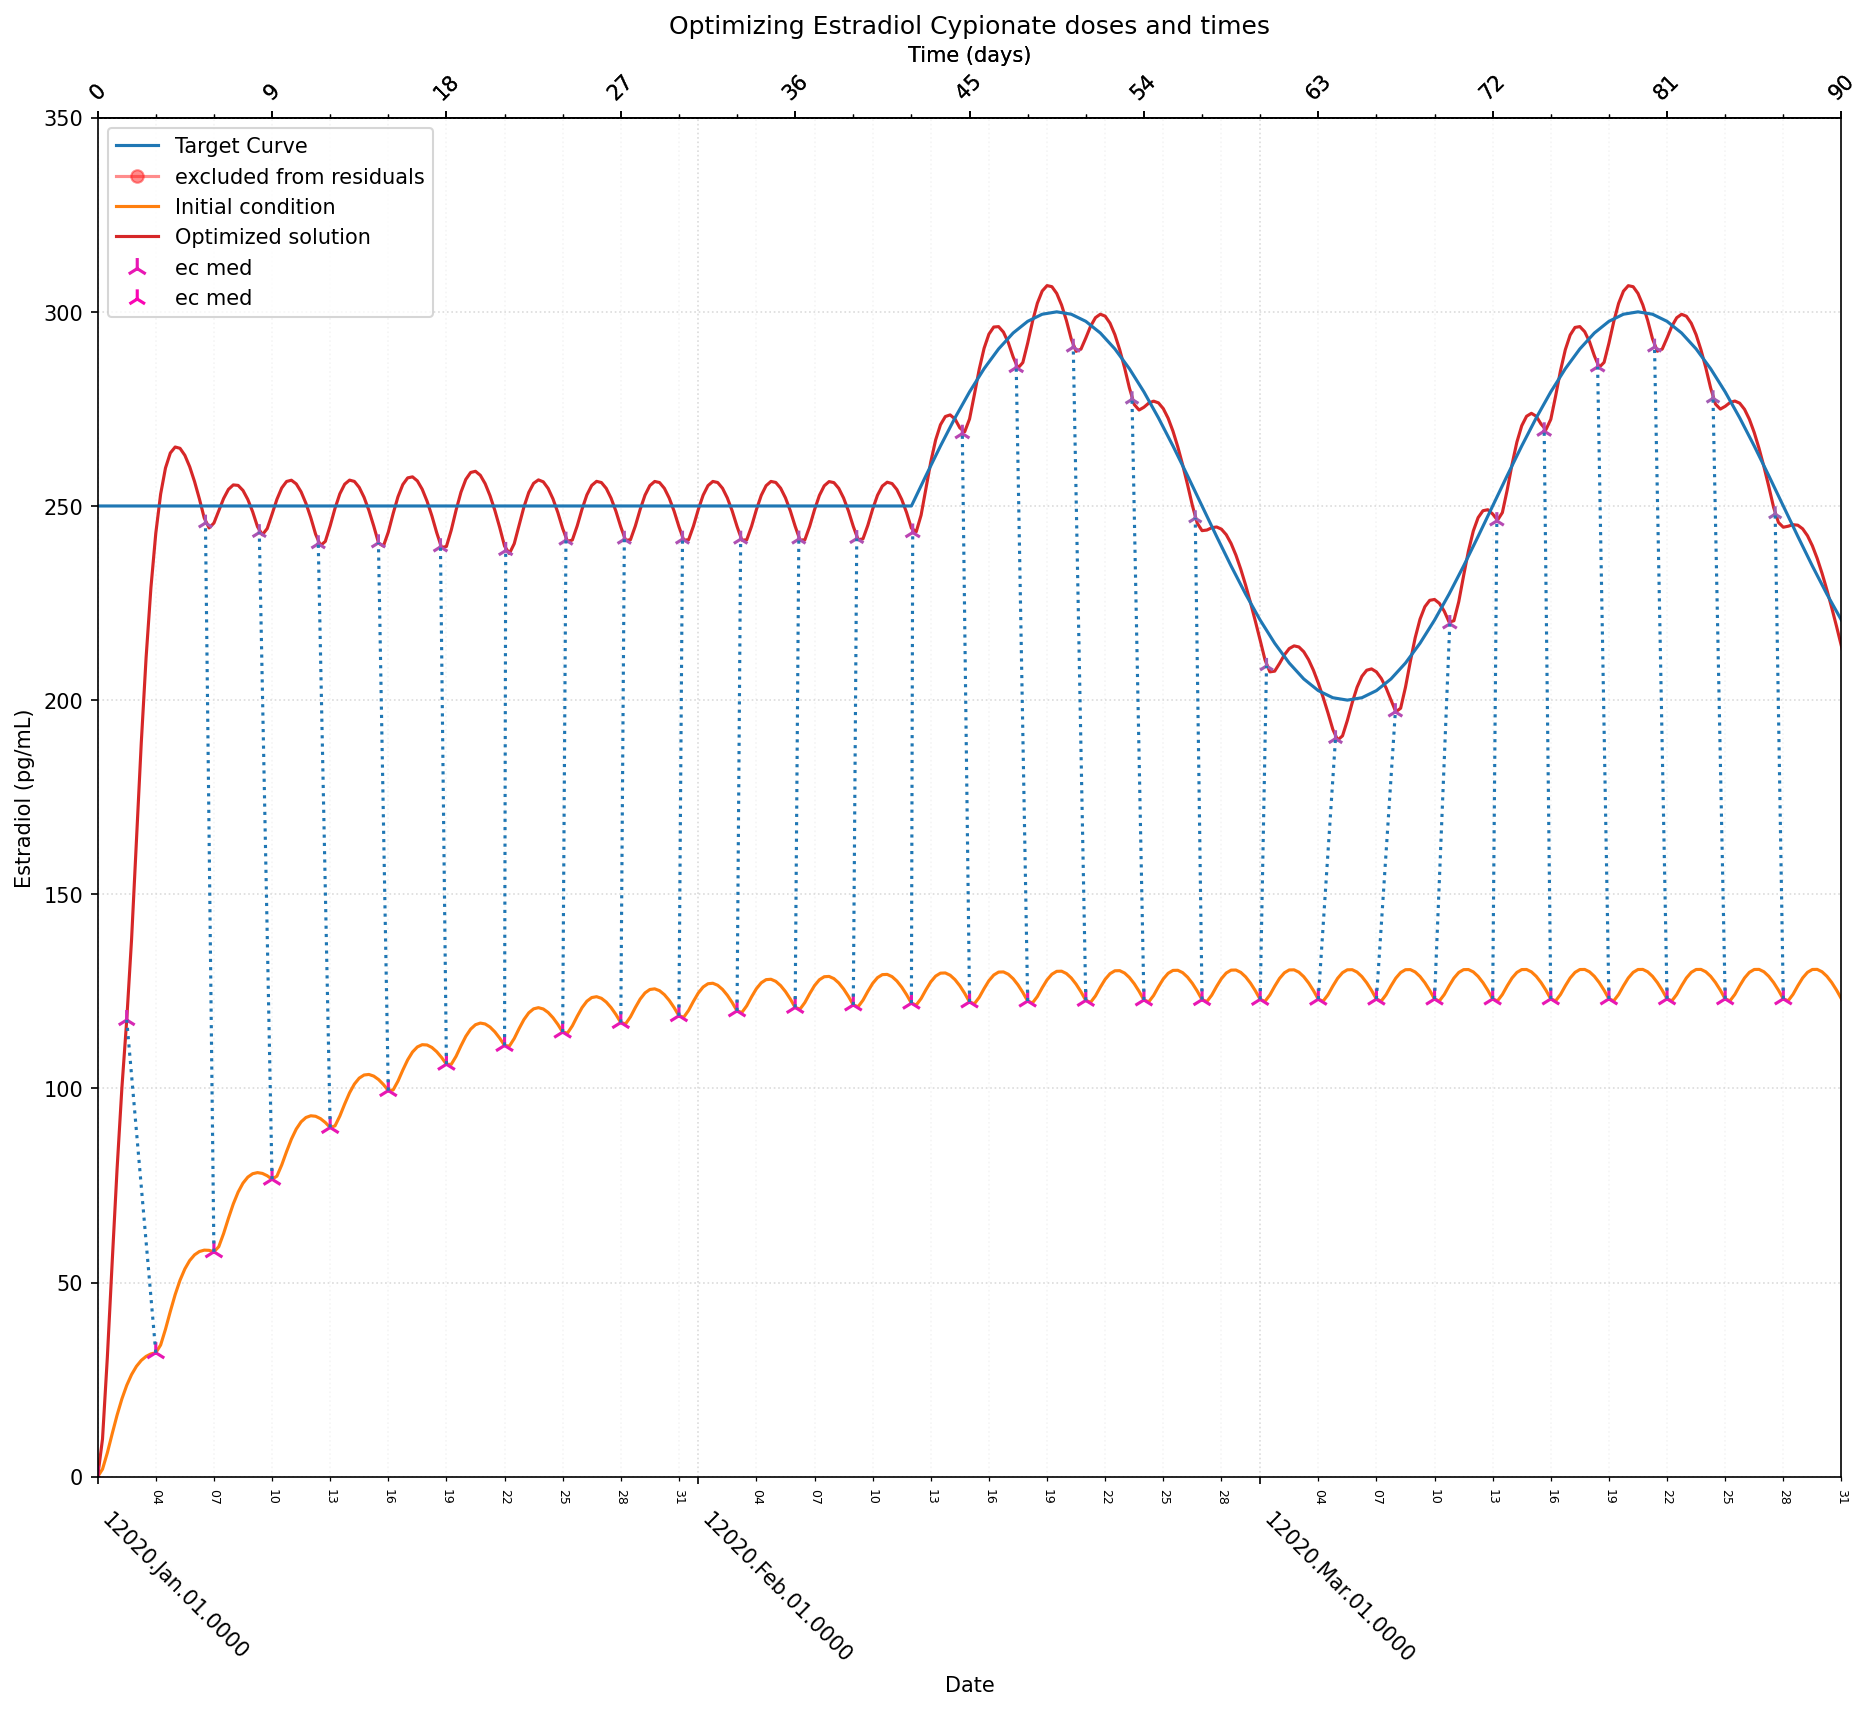

In [14]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Cypionate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ec_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format):
    print("Optimized Doses:\n", sine_results["ec_doses_and_times"]["doses_optim"])

### Least Squares (Estradiol Valerate, Doses & Times)

At reasonable injection schedules, EV struggles with doing any kind of cycling. You can do it alright if you inject more frequently than the single-dose peak ($\tau \lt t_{max}$), but the smoother curve of Estradiol Cypionate makes it more suitable for this use.

In [15]:
doses = pharma.createDosesCycle("ev", 90.0, '3D', start_date="2020")
sine_results["ev_doses_and_times"] = fit.initializeFit(
    doses,
    calibrated_medications,
    sine_target,
    dose_bounds=(0.0, 5.0),
    time_bounds=['fixed'] + (len(doses)-1)*['midpoints'])
fit.runLeastSquares(
    sine_results["ev_doses_and_times"],
    max_nfev=25,
    ftol=1e-3,
    verbose=2);

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6977e+05                                    3.90e+05    
       1              2         6.0974e+04      3.09e+05       2.68e+00       8.40e+04    
       2              3         4.4822e+04      1.62e+04       1.02e+00       1.71e+04    
       3              4         4.3597e+04      1.22e+03       3.45e-01       1.87e+03    
       4              5         4.3572e+04      2.42e+01       5.96e-02       4.55e+01    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 3.6977e+05, final cost 4.3572e+04, first-order optimality 4.55e+01.


Optimized Doses:
                                     dose medication
2020-01-01 00:00:00.000000000      3.198         ev
2020-01-04 14:49:21.651139200      1.027         ev
2020-01-07 10:52:26.342169600      1.245         ev
2020-01-10 10:52:32.498342400      1.245         ev
2020-01-13 10:52:32.556489600      1.245         ev
2020-01-16 10:52:32.552774400      1.245         ev
2020-01-19 10:52:32.544566400      1.245         ev
2020-01-22 10:52:32.535494400      1.245         ev
2020-01-25 10:52:32.530569600      1.245         ev
2020-01-28 10:52:32.529792000      1.245         ev
2020-01-31 10:52:32.534630400      1.245         ev
2020-02-03 10:52:32.543616000      1.245         ev
2020-02-06 10:52:32.533161600      1.245         ev
2020-02-09 10:52:32.549836800      1.245         ev
2020-02-12 11:27:06.417936000      1.535         ev
2020-02-15 10:48:34.969536000      1.583         ev
2020-02-18 10:28:27.452121600      1.494         ev
2020-02-21 10:12:42.079392000      1.311      

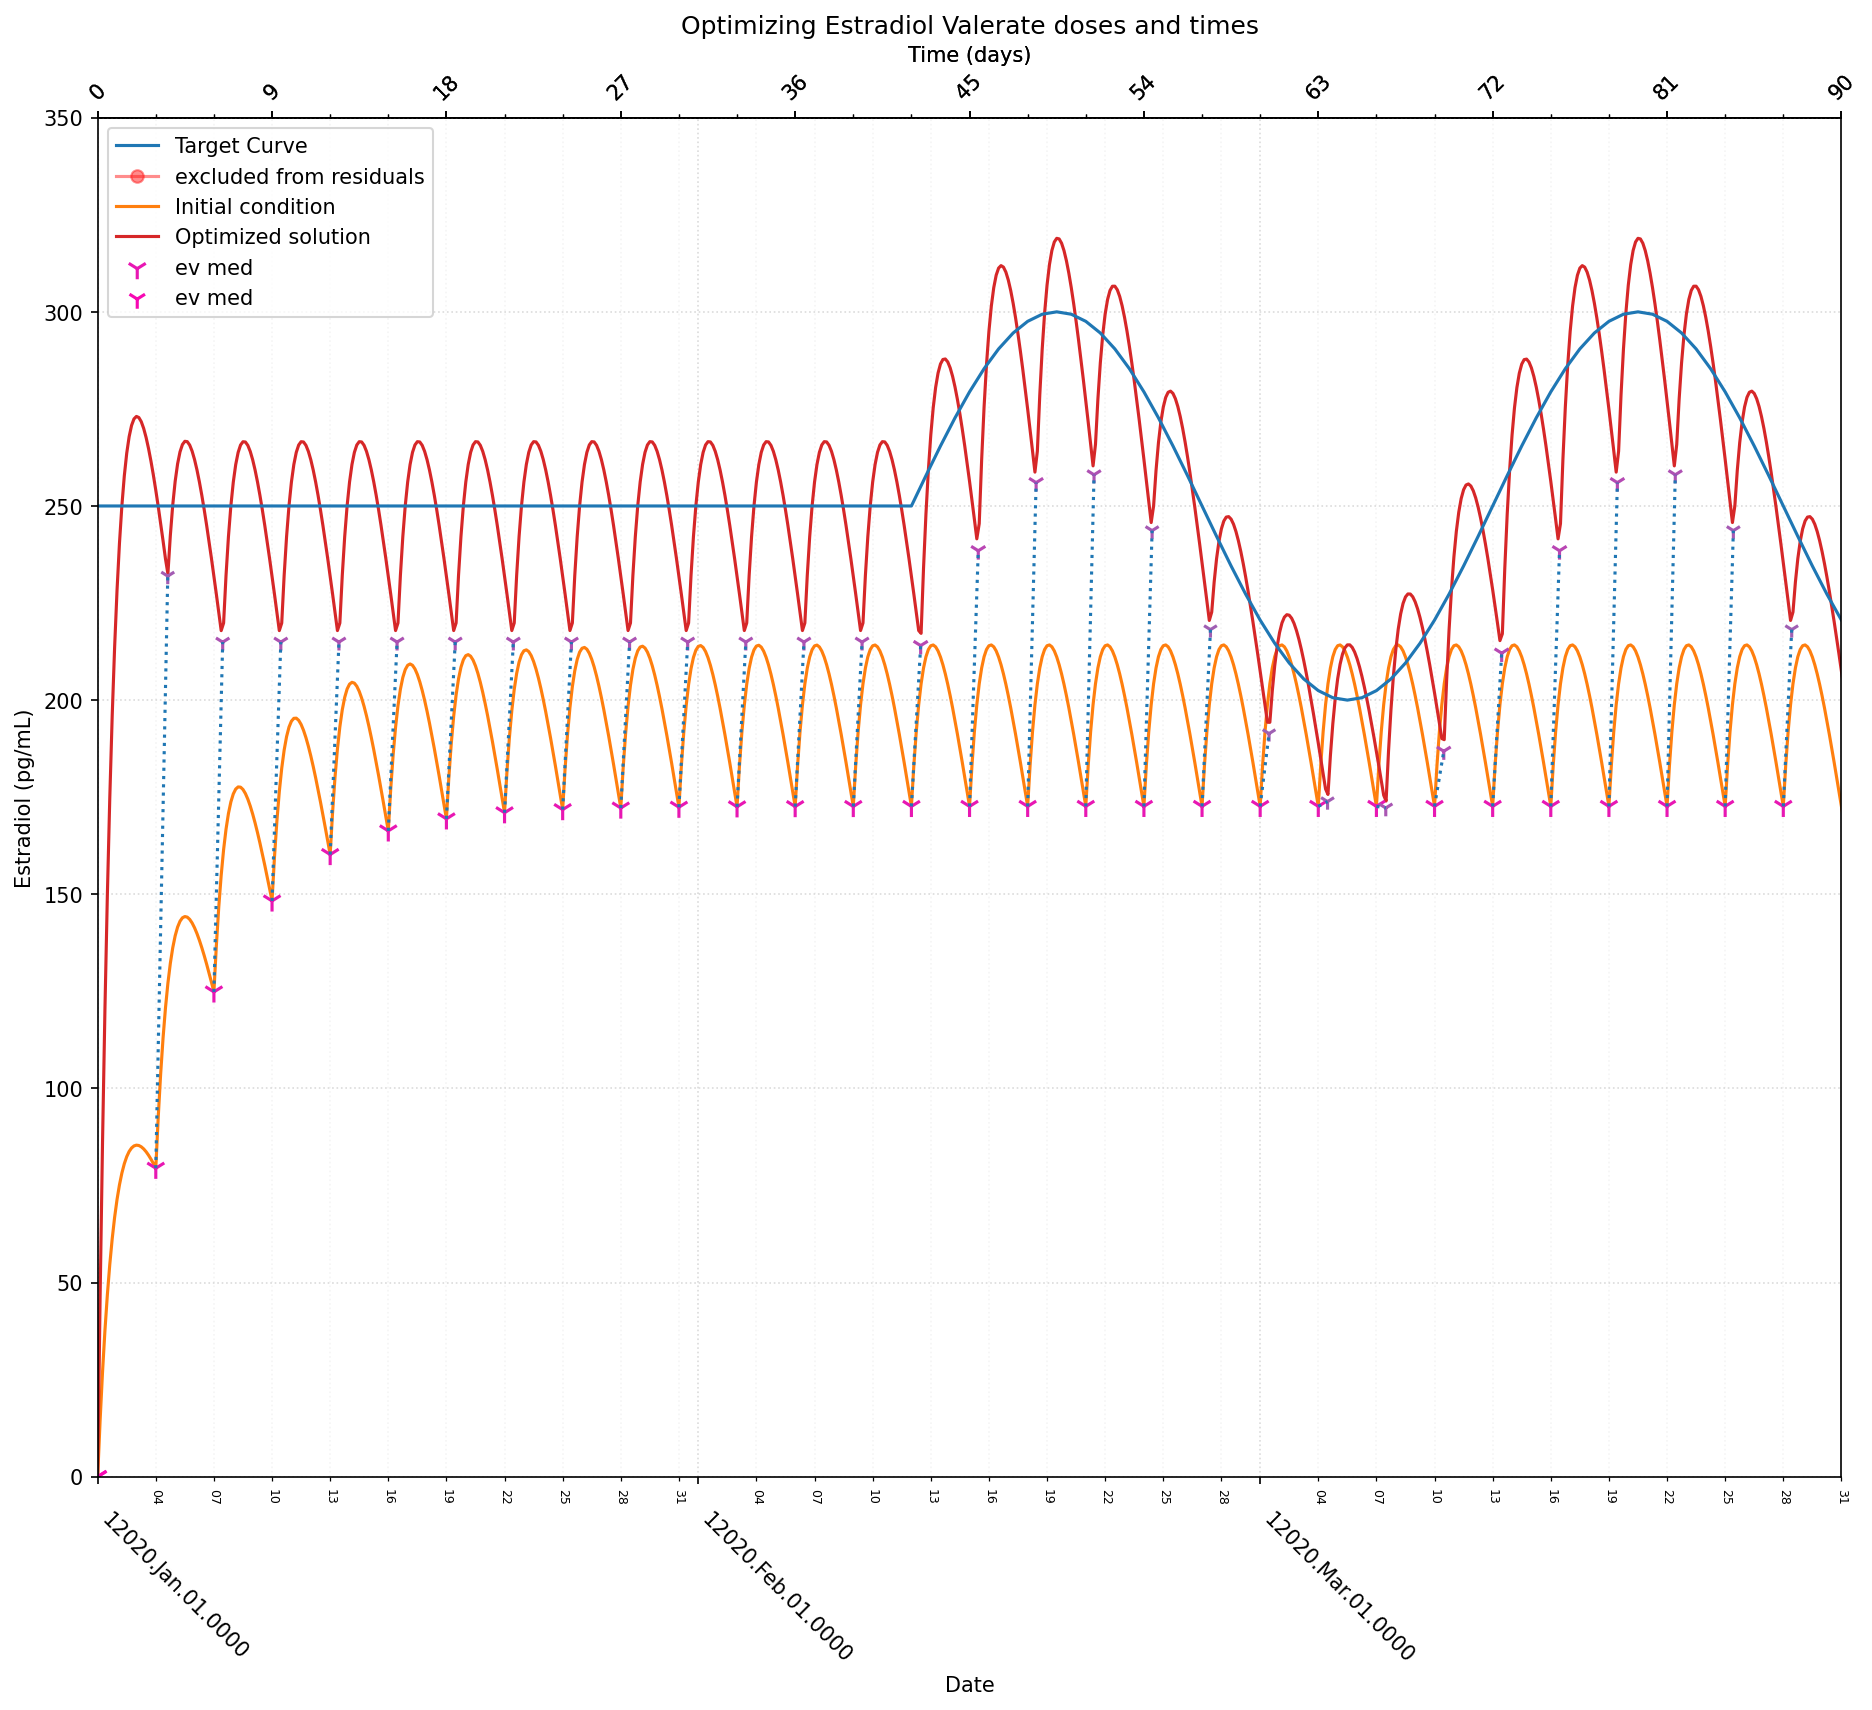

In [17]:
fig,ax = pharma.startPlot()
ax.set_title('Optimizing Estradiol Valerate doses and times')
ax.set_ylim(bottom=0, top=350)
ax.set_yticks(range(0, 351, 50))
fit.plotOptimizationRun(fig, ax, sine_results["ev_doses_and_times"])

with pd.option_context("display.float_format", "{:10,.3f}".format,
                       "display.max_rows", sys.maxsize):
    print("Optimized Doses:\n", sine_results["ev_doses_and_times"]["doses_optim"])